# Multiple Removal Using Parabolic Radon Transform

Author : Muhammad Iqbal Khatami /  195175

The idea of multiple removal is by transforming the CMP gather of seismic data (t-x domain) into radon domain (tau-p domain) and filter/separate the multiple/primary reflection in radon domain. Finally, invert it back to the t-x domain. 

For a more comprehensive explanation about the concept, there is recording of Prof. Erik Verschuur lecture in the course or from this EAGE youtube link : https://www.youtube.com/watch?v=ua3r_KWn7bY

The general workflow of this method is shown below:

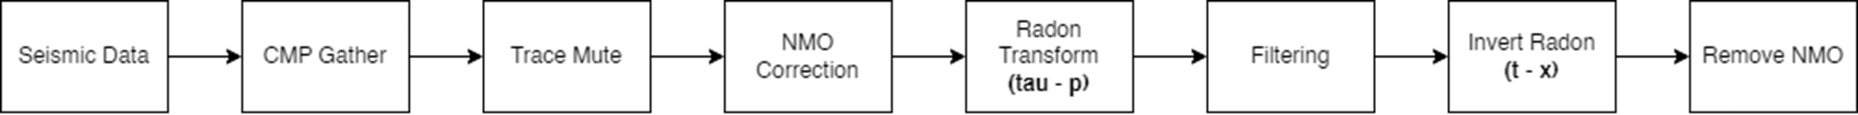

### Import Library

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops

from scipy.signal import butter, lfilter, freqz, medfilt, fftconvolve
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from segyshot import SegyShot
from nmoinv import NMO
from nmo import semblance

# Volve Data

### Load Data

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


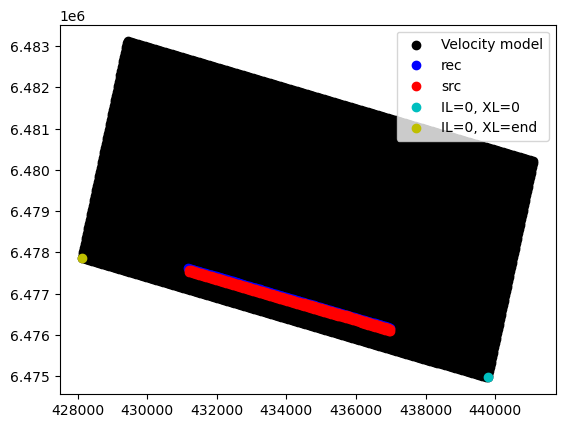

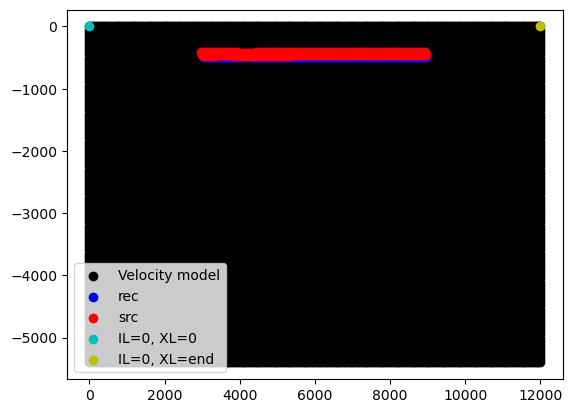

In [2]:
#Import data
inputfile = '../data/ST10010_1150780_40203_2dline2.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

f = segyio.open(inputfile, ignore_geometry=True)
d = segyio.collect(f.trace)
dp=d[::4,:].reshape((240,240,2000))

vmod = segyio.cube(velfile)
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()

#Rotate Geometry
dx,nx,dy,ny=sg.rotategeometry(velfile=velfile, plotflag=1)

### Get CMP gather, mute traces, and NMO Correction

In [3]:
cmp,offset = sg.get_cmp(cmp_idx=100,comp=['P'],half_cmp=True)
cmp = cmp['P']

dx = offset[1]-offset[0]
t = sg.t
dt = t[1]-t[0]
nt = len(t)


In [4]:
#Mute direct and refracted wave
pcut = 1/800

cmp_cut = cmp.copy()
nx = len(offset)
ix = np.arange(nx)
tevent = t[250] + offset * pcut
tevent = (tevent - t[0]) / dt
itevent = tevent.astype(int)
mask = (itevent < nt - 1) & (itevent >= 0)
for i in range(len(offset)):
    if i<len(itevent[mask]):
        cmp_cut[ix[mask][i],:itevent[mask][i]] = 0
    else:
        cmp_cut[i,:nt]=0

#NMO Correction
vnmo = 1100 * np.ones(nt)
NMOOp = NMO(t, offset, vnmo)
datanmo = NMOOp @ cmp_cut

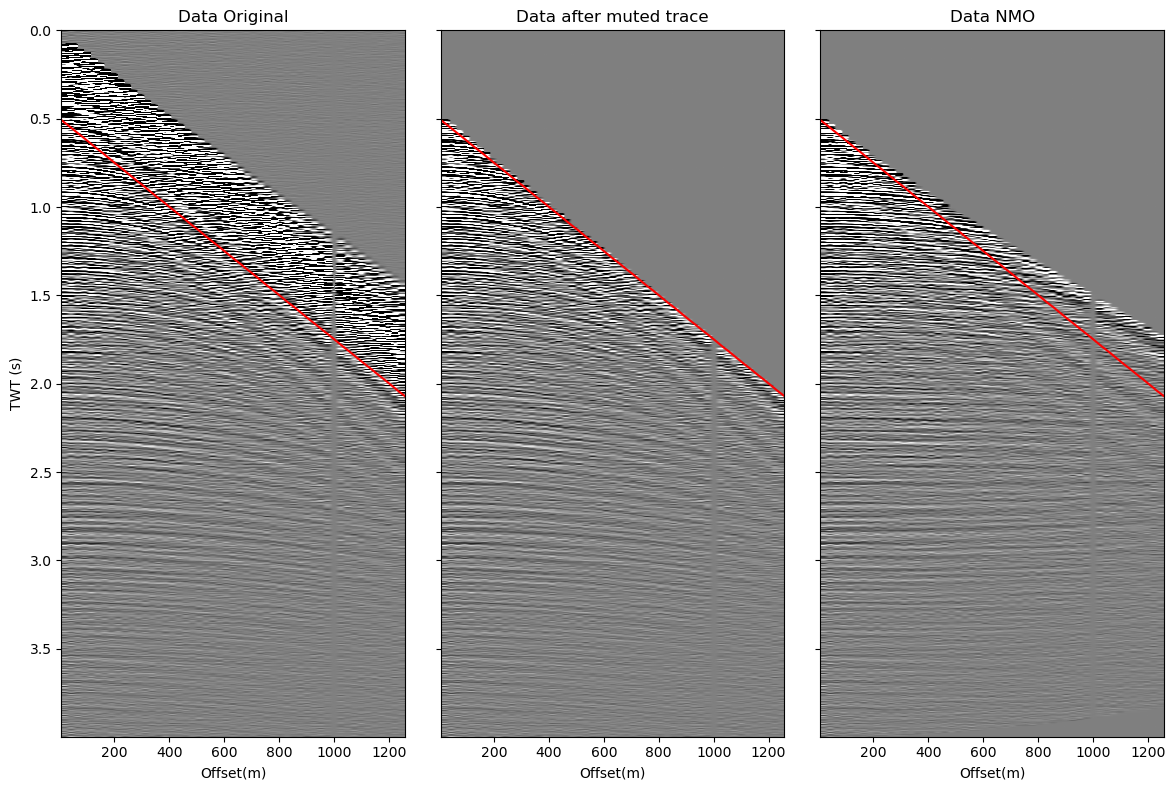

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8),sharey=True)
axs[0].imshow(cmp.T, cmap='gray',vmin=-1e5,vmax=1e5,aspect='auto',
             extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]])
axs[0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0].set_title('Data Original')
axs[0].set_xlabel('Offset(m)')
axs[0].set_ylabel('TWT (s)')

axs[1].imshow(cmp_cut.T, cmap='gray',vmin=-1e5,vmax=1e5,aspect='auto',
             extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]])
axs[1].set_title('Data after muted trace')
axs[1].plot(offset[mask],itevent[mask]*dt,c='red')
axs[1].set_xlabel('Offset(m)')

axs[2].imshow(datanmo.T, cmap='gray',vmin=-1e5,vmax=1e5,aspect='auto',
             extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]])
axs[2].set_title('Data NMO')
axs[2].plot(offset[mask],itevent[mask]*dt,c='red')
axs[2].set_xlabel('Offset(m)')

plt.savefig('Original,Muted, NMO Volve')
plt.tight_layout()
plt.show()

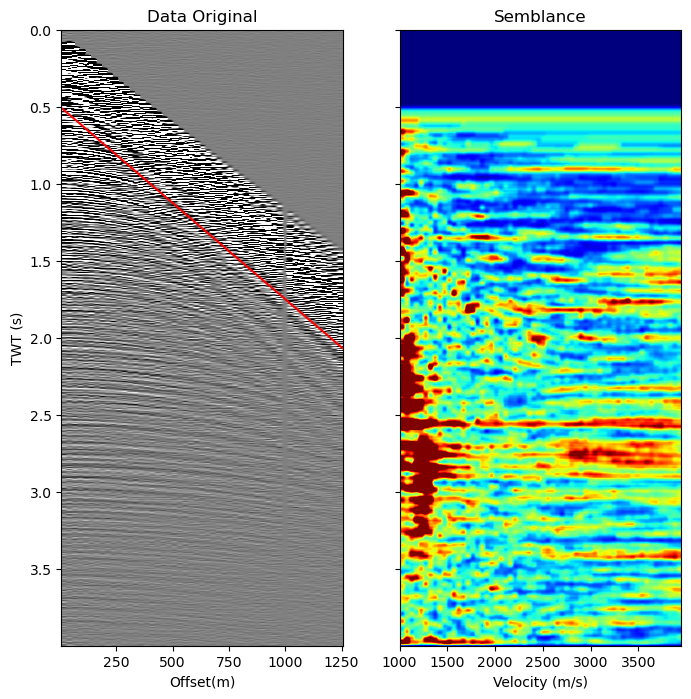

In [6]:
t0axis = sg.t
vrmsaxis = np.arange(1000, 4000, 50)
clip = 0.9

ss,_ = semblance(cmp_cut.T, offset, t, t0axis, vrmsaxis, nsmooth=15)

fig, axs = plt.subplots(1, 2 ,figsize=(8, 8),sharey=True)

axs[0].imshow(cmp.T, cmap='gray',vmin=-1e5,vmax=1e5,aspect='auto', extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]])
axs[0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0].set_title('Data Original')
axs[0].set_xlabel('Offset(m)')
axs[0].set_ylabel('TWT (s)')

axs[1].imshow(ss, cmap='jet', vmin=0, vmax=ss.max()*0.3,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],sg.t[-1],sg.t[0]])
axs[1].set_title('Semblance')
axs[1].set_xlabel('Velocity (m/s)')

plt.savefig('Original Semblance_Volve')
plt.show()

### Radon Transform

In [7]:
npx = 4000
pxmax = 400e-4 / 2 #s/m
px = np.linspace(-pxmax, pxmax, npx) / dx #s/m^2

In [8]:
RPop = pylops.signalprocessing.Radon2D(
    t, offset, px, centeredh=False, kind="parabolic", interp=True, engine="numba"
)

In [9]:
xinv, niter, cost = pylops.optimization.sparsity.fista(
    RPop, datanmo.ravel(), niter=100, eps=1e1
)
xinv = xinv.reshape(RPop.dims)

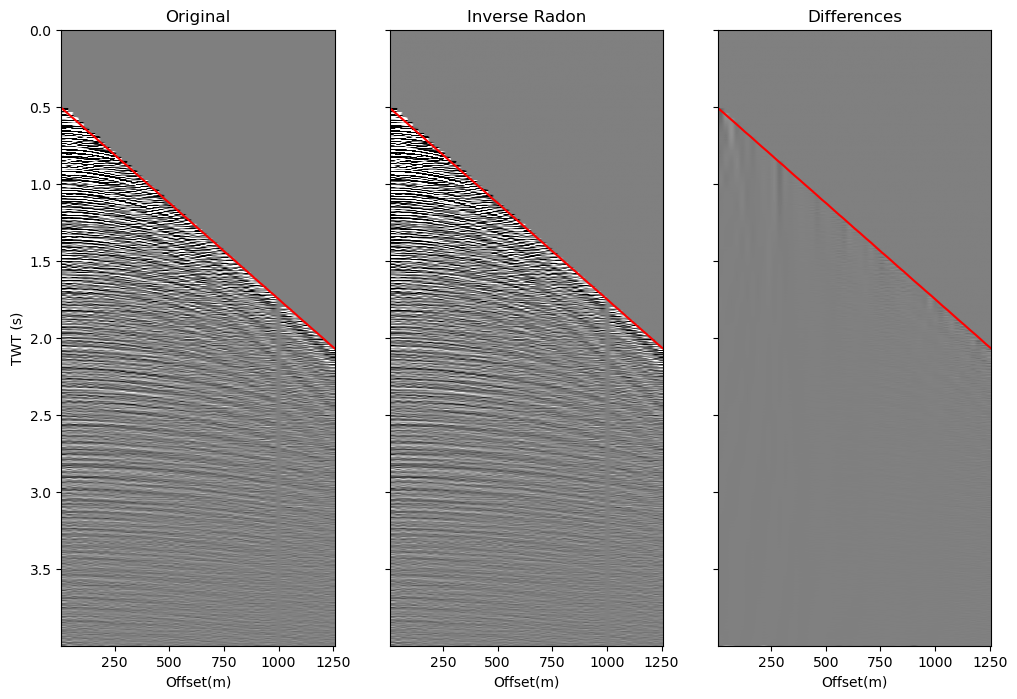

In [10]:
#Compare Radon and Original
y = RPop * xinv
y = NMOOp.div(y.ravel()).reshape(nx, nt)

for i in range(len(offset)):
    if i<len(itevent[mask]):
        y[ix[mask][i],:itevent[mask][i]] = 0
    else:
        y[i,:nt]=0

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 8))
axs[0].imshow(cmp_cut.T,aspect='auto',vmax=1e5,vmin=-1e5,extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],cmap='gray')
axs[0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0].set_xlabel('Offset(m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Original')

axs[1].imshow(y.T,aspect='auto',vmax=1e5,vmin=-1e5,extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],cmap='gray')
axs[1].set_xlabel('Offset(m)')
axs[1].plot(offset[mask],itevent[mask]*dt,c='red')
axs[1].set_title('Inverse Radon')

axs[2].imshow(cmp_cut.T-y.T,aspect='auto',vmax=1e5,vmin=-1e5,extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],cmap='gray')
axs[2].set_xlabel('Offset(m)')
axs[2].plot(offset[mask],itevent[mask]*dt,c='red')
axs[2].set_title('Differences')

plt.savefig('Original Comparison_Volve')
plt.show()

### Radon filtering and Invert back to t-x domain

In [11]:
filt_prim = np.zeros_like(xinv)
filt_mult = np.zeros_like(xinv)
filt_dmult = np.zeros_like(xinv)

tolerance = 10
idx_bot = npx//2 - tolerance
idx_up = npx//2 + 2

filt_prim[idx_bot : idx_up,1350:] = xinv[idx_bot : idx_up,1350:]
filt_prim[idx_bot : idx_up+5, :1350] = xinv[idx_bot : idx_up+5,:1350]

filt_mult[idx_up:,1350:] = xinv[idx_up:,1350:]
filt_mult[idx_up+5:,:1350] = xinv[idx_up+5:,:1350]

filt_dmult[:idx_up,1350:] = xinv[:idx_up,1350:]
filt_dmult[:idx_up+5,:1350] = xinv[:idx_up+5,:1350]

prim = RPop * filt_prim
mult = RPop * filt_mult
dmult = RPop * filt_dmult

In [12]:
prim = NMOOp.div(prim.ravel()).reshape(nx, nt)
mult = NMOOp.div(mult.ravel()).reshape(nx, nt)
dmult = NMOOp.div(dmult.ravel()).reshape(nx, nt)

for i in range(len(offset)):
    if i<len(itevent[mask]):
        prim[ix[mask][i],:itevent[mask][i]] = 0
        mult[ix[mask][i],:itevent[mask][i]] = 0
        dmult[ix[mask][i],:itevent[mask][i]] = 0
    else:
        prim[i,:nt]=0
        mult[i,:nt]=0
        dmult[i,:nt]=0


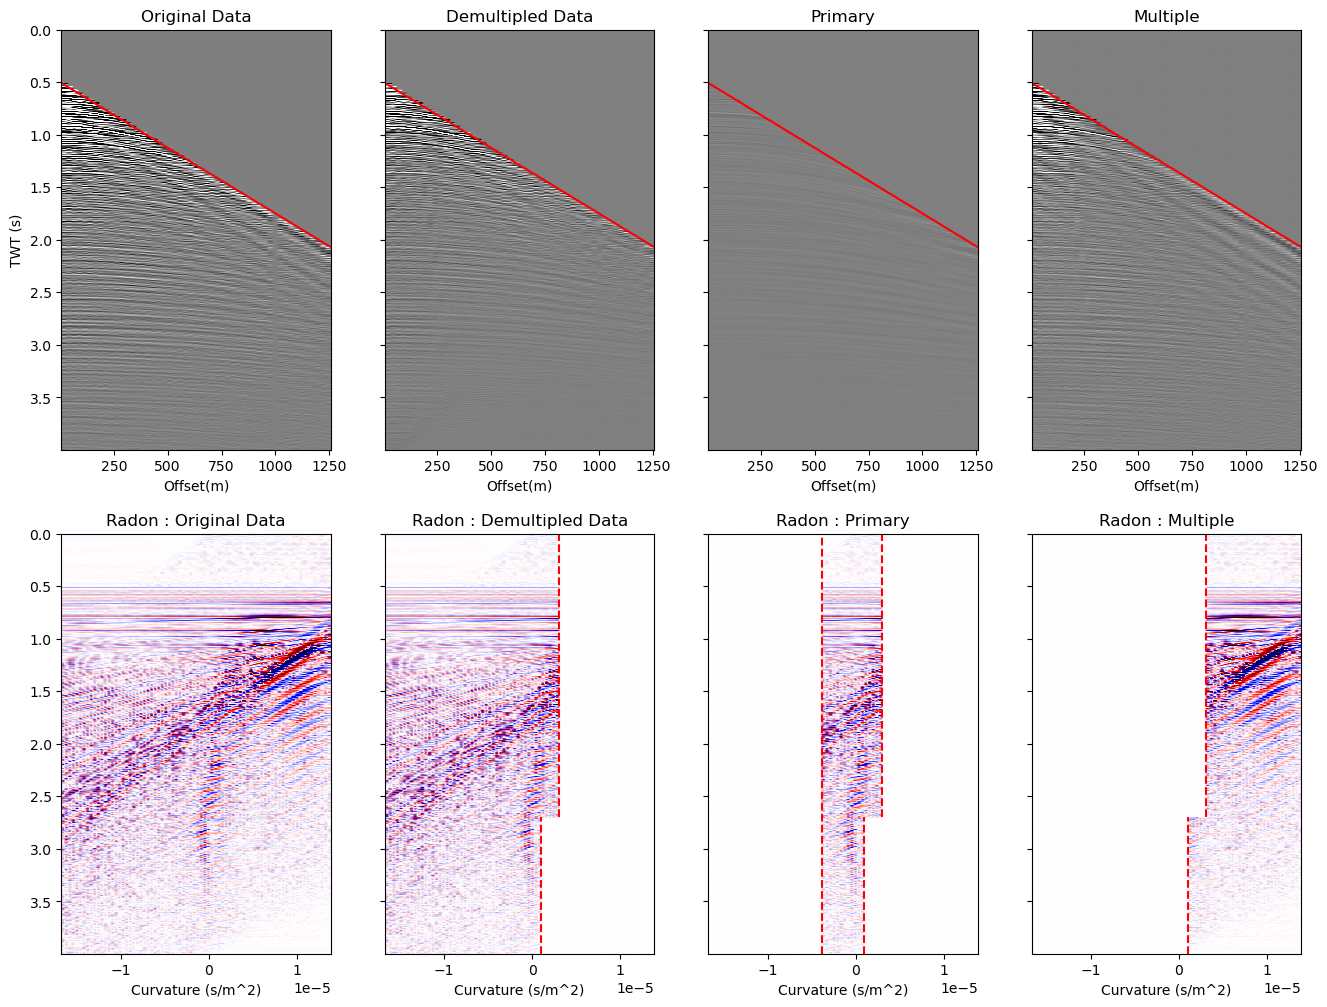

In [13]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(16, 12))

plot_tol = 32

axs[0,0].imshow(cmp_cut.T, cmap='gray',extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],vmin=-1e5,vmax=1e5,aspect='auto')
axs[0,0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,0].set_xlabel('Offset(m)')
axs[0,0].set_ylabel('TWT (s)')
axs[0,0].set_title('Original Data')

axs[0,2].imshow(prim.T, cmap='gray',extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],vmin=-1e5,vmax=1e5,aspect='auto')
axs[0,2].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,2].set_xlabel('Offset(m)')
axs[0,2].set_title('Primary')

axs[0,3].imshow(mult.T, cmap='gray',extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],vmin=-1e5,vmax=1e5,aspect='auto')
axs[0,3].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,3].set_xlabel('Offset(m)')
axs[0,3].set_title('Multiple')

axs[0,1].imshow(dmult.T, cmap='gray',extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],vmin=-1e5,vmax=1e5,aspect='auto')
axs[0,1].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,1].set_xlabel('Offset(m)')
axs[0,1].set_title('Demultipled Data')

axs[1,0].imshow(xinv[idx_bot-plot_tol:idx_up+plot_tol,:].T,aspect='auto',vmax=0.2e4,vmin=-0.2e4,
              extent=[px[idx_bot-plot_tol],px[idx_up+plot_tol],sg.t[-1],sg.t[0]],cmap='seismic')

axs[1,0].set_title("Radon : Original Data")
axs[1,0].set_xlabel('Curvature (s/m^2)')

axs[1,2].imshow(filt_prim[idx_bot-plot_tol:idx_up+plot_tol,:].T,aspect='auto',vmax=0.2e4,vmin=-0.2e4,
              extent=[px[idx_bot-plot_tol],px[idx_up+plot_tol],sg.t[-1],sg.t[0]],cmap='seismic')

axs[1,2].axvline(px[idx_bot],color="r", linestyle="--")
axs[1,2].axvline(px[idx_up],ymin=0,ymax=0.325,color="r", linestyle="--")
axs[1,2].axvline(px[idx_up+5],ymin=0.325,color="r", linestyle="--")
axs[1,2].set_title("Radon : Primary")
axs[1,2].set_xlabel('Curvature (s/m^2)')

axs[1,3].imshow(filt_mult[idx_bot-plot_tol:idx_up+plot_tol,:].T,aspect='auto',vmax=0.2e4,vmin=-0.2e4,
              extent=[px[idx_bot-plot_tol],px[idx_up+plot_tol],sg.t[-1],sg.t[0]],cmap='seismic')

axs[1,3].axvline(px[idx_up],ymin=0,ymax=0.325,color="r", linestyle="--")
axs[1,3].axvline(px[idx_up+5],ymin=0.325,color="r", linestyle="--")
axs[1,3].set_title("Radon : Multiple")
axs[1,3].set_xlabel('Curvature (s/m^2)')


axs[1,1].imshow(filt_dmult[idx_bot-plot_tol:idx_up+plot_tol,:].T,aspect='auto',vmax=0.2e4,vmin=-0.2e4,
              extent=[px[idx_bot-plot_tol],px[idx_up+plot_tol],sg.t[-1],sg.t[0]],cmap='seismic')

axs[1,1].axvline(px[idx_up],ymin=0,ymax=0.325,color="r", linestyle="--")
axs[1,1].axvline(px[idx_up+5],ymin=0.325,color="r", linestyle="--")
axs[1,1].set_title("Radon : Demultipled Data")
axs[1,1].set_xlabel('Curvature (s/m^2)')

plt.savefig('Radon Result_Volve')

plt.show()

### Check Semblance

In [14]:
t0axis = sg.t
vrmsaxis = np.arange(1000, 4000, 50)
clip = 0.9

ss_prim,_ = semblance(prim.T, offset, t, t0axis, vrmsaxis, nsmooth=15)
ss_mult,_ = semblance(mult.T, offset, t, t0axis, vrmsaxis, nsmooth=15)
ss_dmult,_ = semblance(dmult.T, offset, t, t0axis, vrmsaxis, nsmooth=15)
ss_ori,_ = semblance(cmp_cut.T, offset, t, t0axis, vrmsaxis, nsmooth=15)

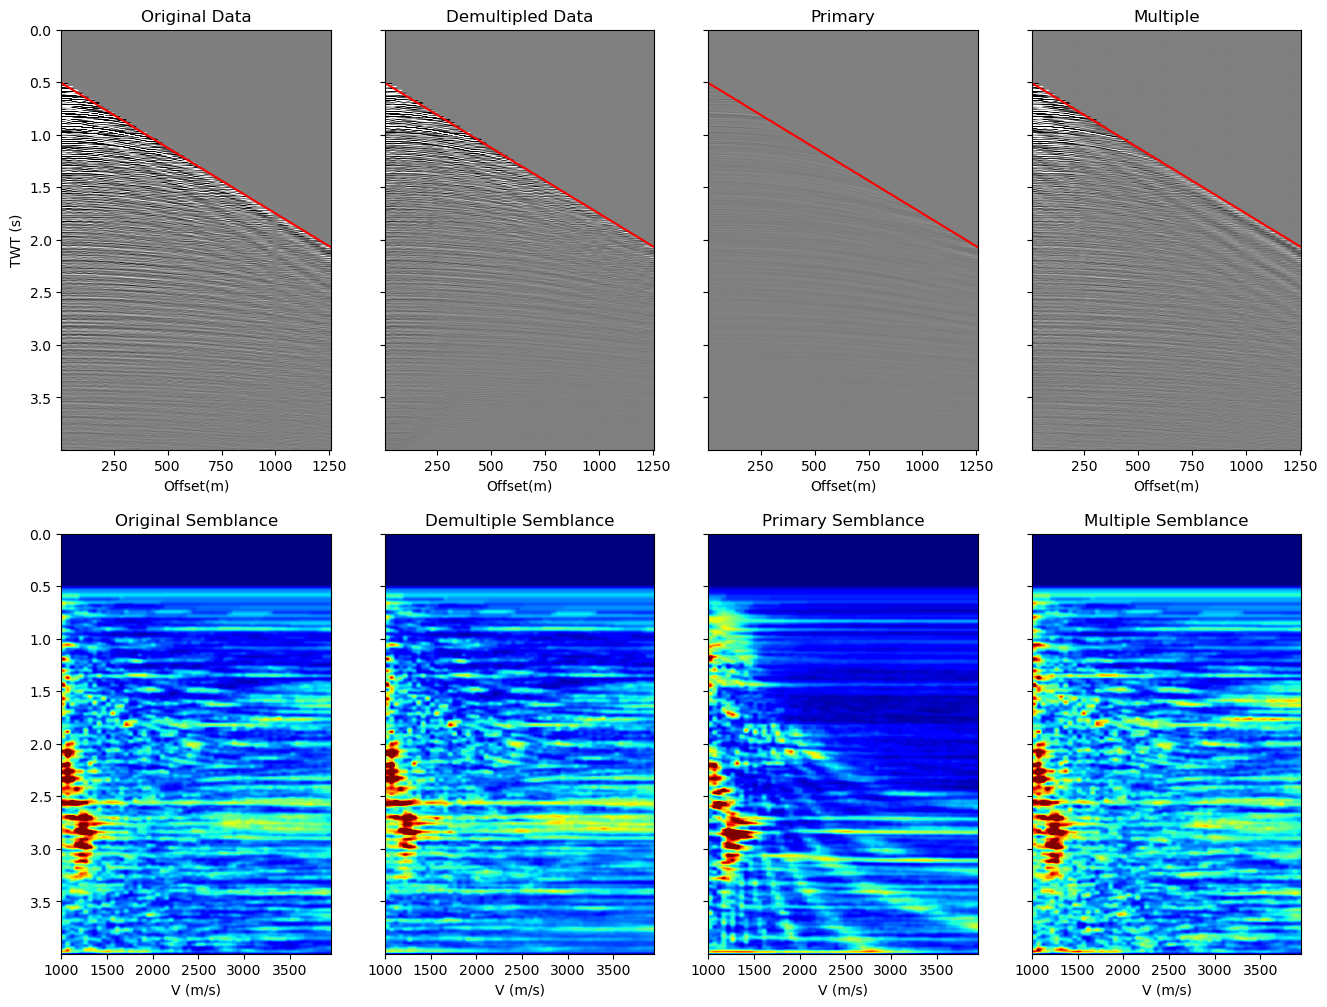

In [15]:
fig, axs = plt.subplots(2, 4 ,figsize=(16, 12),sharey=True)
clip = 0.5

axs[0,0].imshow(cmp_cut.T, cmap='gray',extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],vmin=-1e5,vmax=1e5,aspect='auto')
axs[0,0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,0].set_xlabel('Offset(m)')
axs[0,0].set_ylabel('TWT (s)')
axs[0,0].set_title('Original Data')

axs[0,1].imshow(dmult.T, cmap='gray',extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],vmin=-1e5,vmax=1e5,aspect='auto')
axs[0,1].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,1].set_xlabel('Offset(m)')
axs[0,1].set_title('Demultipled Data')

axs[0,3].imshow(mult.T, cmap='gray',extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],vmin=-1e5,vmax=1e5,aspect='auto')
axs[0,3].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,3].set_xlabel('Offset(m)')
axs[0,3].set_title('Multiple')

axs[0,2].imshow(prim.T, cmap='gray',extent=[offset[0],offset[-1],sg.t[-1],sg.t[0]],vmin=-1e5,vmax=1e5,aspect='auto')
axs[0,2].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,2].set_xlabel('Offset(m)')
axs[0,2].set_title('Primary')

axs[1,0].imshow(ss_ori, cmap='jet', vmin=0, vmax=ss_ori.max()*clip,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],sg.t[-1],sg.t[0]])
axs[1,0].set_title('Original Semblance')
axs[1,0].set_xlabel('V (m/s)')

axs[1,3].imshow(ss_mult, cmap='jet', vmin=0, vmax=ss_mult.max()*clip,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],sg.t[-1],sg.t[0]])
axs[1,3].set_title('Multiple Semblance')
axs[1,3].set_xlabel('V (m/s)')

axs[1,2].imshow(ss_prim, cmap='jet', vmin=0, vmax=ss_prim.max()*clip,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],sg.t[-1],sg.t[0]])
axs[1,2].set_title('Primary Semblance')
axs[1,2].set_xlabel('V (m/s)')

axs[1,1].imshow(ss_dmult, cmap='jet', vmin=0, vmax=ss_dmult.max()*clip,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],sg.t[-1],sg.t[0]])
axs[1,1].set_title('Demultiple Semblance')
axs[1,1].set_xlabel('V (m/s)')


plt.savefig('Semblance Check_Volve')
plt.show()

# Mobil AVO (Towed Streamer)

This dataset can be downloaded from https://wiki.seg.org/wiki/Mobil_AVO_viking_graben_line_12

### Load Data and get CMP gather

In [16]:
f = segyio.open('../data/mobilavo.segy', ignore_geometry=True)
data = segyio.collect(f.trace[:])

ns = 1001
nr = 120
nt = 1500

gx=f.attributes(segyio.TraceField.GroupX)[:]
sx=f.attributes(segyio.TraceField.SourceX)[:]
gz=-f.attributes(segyio.TraceField.ReceiverGroupElevation)[:]
sz=-f.attributes(segyio.TraceField.SourceSurfaceElevation)[:]
dr = np.diff(gx)[0]
ds = np.diff(sx[::nr])[0]
dt = (f.samples[1]-f.samples[0])/1000

data3d = data.reshape(ns, nr, nt)
gx3d = gx.reshape(ns, nr)
sx3d = sx.reshape(ns, nr)

t = f.samples/1000

In [17]:
idx_src = np.arange(0,nr//2,1)
idx_rec = np.arange(119,-1,-2)

cmp = data3d[idx_src,idx_rec,:]
offset = sx3d[idx_src,idx_rec] - gx3d[idx_src,idx_rec]

### NMO Correction

In [18]:
dx = offset[1]-offset[0]
nt = len(t)
vnmo = 1800 * np.ones(nt)

In [19]:
cmp_cut = cmp.copy()

nx = len(offset)
ix = np.arange(nx)

tevent = t[75]+(offset/1750)
ref = np.arange(70,10,-1)
# tevent = (tevent - t[0]) / dt + ref
tevent = (tevent - t[0]) / dt 

itevent = tevent.astype(int)
mask = (itevent < nt - 1) & (itevent >= 0)
for i in range(len(offset)):
    if i<len(itevent[mask]):
        cmp_cut[ix[mask][i],:itevent[mask][i]] = 0
    else:
        cmp_cut[i,:nt]=0
        
NMOOporig = NMO(t, offset, vnmo)
dataorignmo = NMOOporig @ cmp_cut

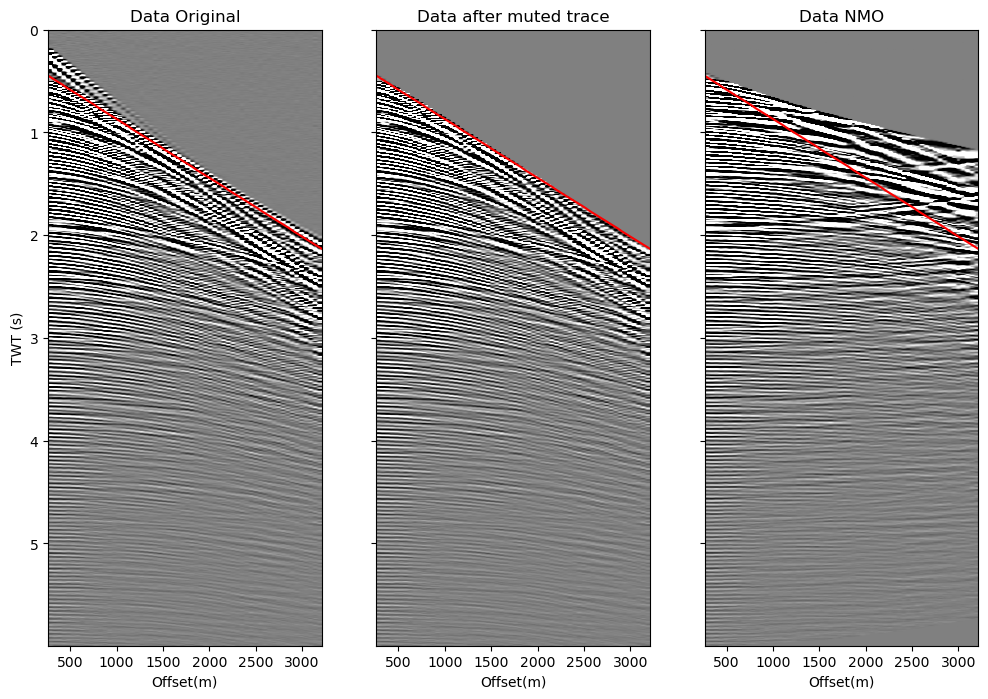

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8),sharey=True)
axs[0].imshow(cmp.T, cmap='gray',vmin=-10,vmax=10,aspect='auto',
             extent=[offset[0],offset[-1],t[-1],t[0]])
axs[0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0].set_title('Data Original')
axs[0].set_xlabel('Offset(m)')
axs[0].set_ylabel('TWT (s)')

axs[1].imshow(cmp_cut.T, cmap='gray',vmin=-10,vmax=10,aspect='auto',
             extent=[offset[0],offset[-1],t[-1],t[0]])
axs[1].set_title('Data after muted trace')
axs[1].plot(offset[mask],itevent[mask]*dt,c='red')
axs[1].set_xlabel('Offset(m)')

axs[2].imshow(dataorignmo.T, cmap='gray',vmin=-10,vmax=10,aspect='auto',
             extent=[offset[0],offset[-1],t[-1],t[0]])
axs[2].set_title('Data NMO')
axs[2].plot(offset[mask],itevent[mask]*dt,c='red')
axs[2].set_xlabel('Offset(m)')

plt.savefig('Original_Muted_NMO_MOBIL')
plt.show()

In [21]:
t0axis = t
vrmsaxis = np.arange(1500, 4000, 50)
clip = 0.9

ss,_ = semblance(cmp_cut.T, offset, t, t0axis, vrmsaxis, nsmooth=15)

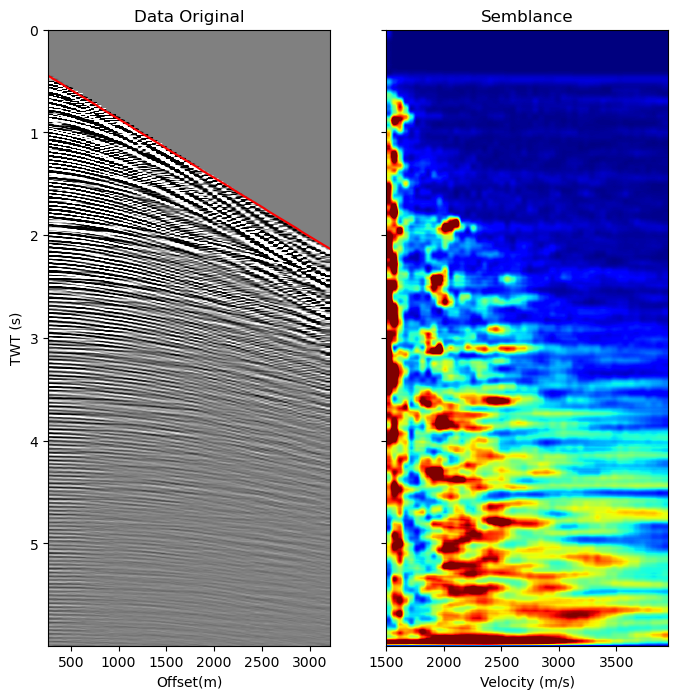

In [22]:
fig, axs = plt.subplots(1, 2 ,figsize=(8, 8),sharey=True)

axs[0].imshow(cmp_cut.T, cmap='gray',vmin=-10,vmax=10,aspect='auto', extent=[offset[0],offset[-1],t[-1],t[0]])
axs[0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0].set_title('Data Original')
axs[0].set_ylabel('TWT (s)')
axs[0].set_xlabel('Offset(m)')

axs[1].imshow(ss, cmap='jet', vmin=0, vmax=ss.max()*0.5,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],t[-1],t[0]])
axs[1].set_title('Semblance')
axs[1].set_xlabel('Velocity (m/s)')


plt.savefig('Original Semblance_MOBIL')
plt.show()

axs[1].set_title('Semblance')
plt.show()

### Radon Transform

In [23]:
npx = 2000
pxmax = 100e-4 / 2 #s/m
px = np.linspace(-pxmax, pxmax, npx) / dx #s/m^2

RPop = pylops.signalprocessing.Radon2D(
    t, offset, px, centeredh=False, kind="parabolic", interp=True, engine="numba"
)

In [24]:
xinv, niter, cost = pylops.optimization.sparsity.fista(
    RPop, dataorignmo.ravel(), niter=200, eps=1
)
xinv = xinv.reshape(RPop.dims)

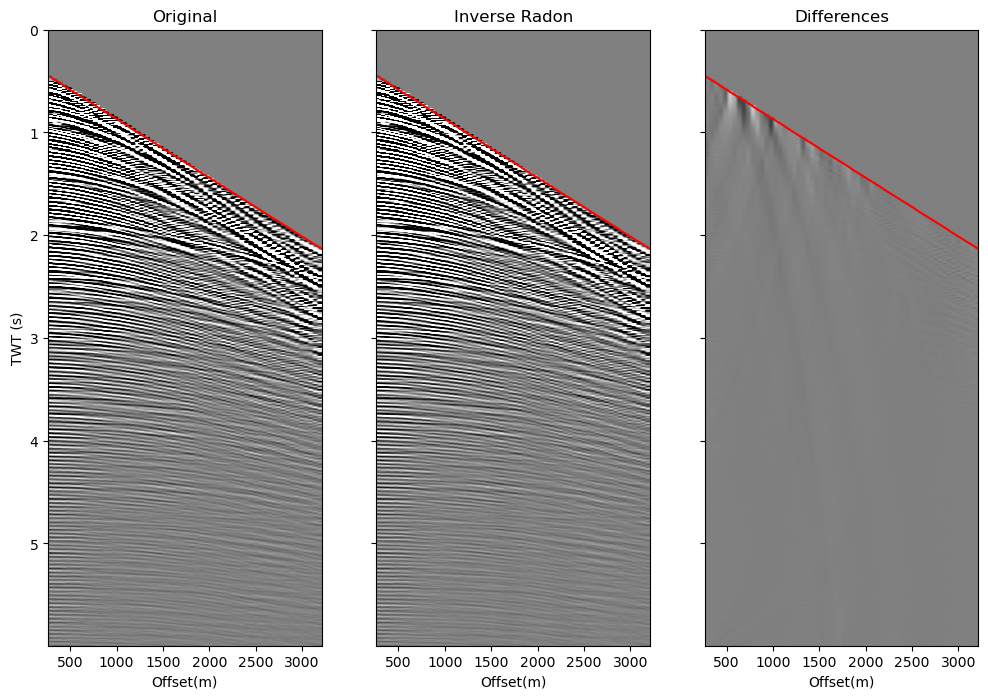

In [25]:
#Compare Radon and Original
y = RPop * xinv
y = NMOOporig.div(y.ravel()).reshape(nx, nt)

for i in range(len(offset)):
    if i<len(itevent[mask]):
        y[ix[mask][i],:itevent[mask][i]] = 0
    else:
        y[i,:nt]=0

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 8))
axs[0].imshow(cmp_cut.T,aspect='auto',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],cmap='gray')
axs[0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0].set_xlabel('Offset(m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Original')

axs[1].imshow(y.T,aspect='auto',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],cmap='gray')
axs[1].set_xlabel('Offset(m)')
axs[1].plot(offset[mask],itevent[mask]*dt,c='red')
axs[1].set_title('Inverse Radon')

axs[2].imshow(cmp_cut.T-y.T,aspect='auto',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],cmap='gray')
axs[2].set_xlabel('Offset(m)')
axs[2].plot(offset[mask],itevent[mask]*dt,c='red')
axs[2].set_title('Differences')

plt.savefig('Original Comparison_MOBIL')
plt.show()

### Radon Filtering

In [27]:
filt_prim = np.zeros_like(xinv)
filt_mult = np.zeros_like(xinv)
filt_dmult = np.zeros_like(xinv)

top_tolerance = 3
bot_tolerance = 20
idx_bot = npx//2 - bot_tolerance
idx_up = npx//2 + top_tolerance

filt_prim[idx_bot : idx_up] = xinv[idx_bot : idx_up]
filt_mult[idx_up:] = xinv[idx_up:]
filt_dmult[:idx_up] = xinv[:idx_up]

prim = RPop * filt_prim
mult = RPop * filt_mult
dmult = RPop * filt_dmult

In [28]:
prim = NMOOporig.div(prim.ravel()).reshape(nx, nt)
mult = NMOOporig.div(mult.ravel()).reshape(nx, nt)
dmult = NMOOporig.div(dmult.ravel()).reshape(nx, nt)

for i in range(len(offset)):
    if i<len(itevent[mask]):
        prim[ix[mask][i],:itevent[mask][i]] = 0
        mult[ix[mask][i],:itevent[mask][i]] = 0
        dmult[ix[mask][i],:itevent[mask][i]] = 0
    else:
        prim[i,:nt]=0
        mult[i,:nt]=0
        dmult[i,:nt]=0


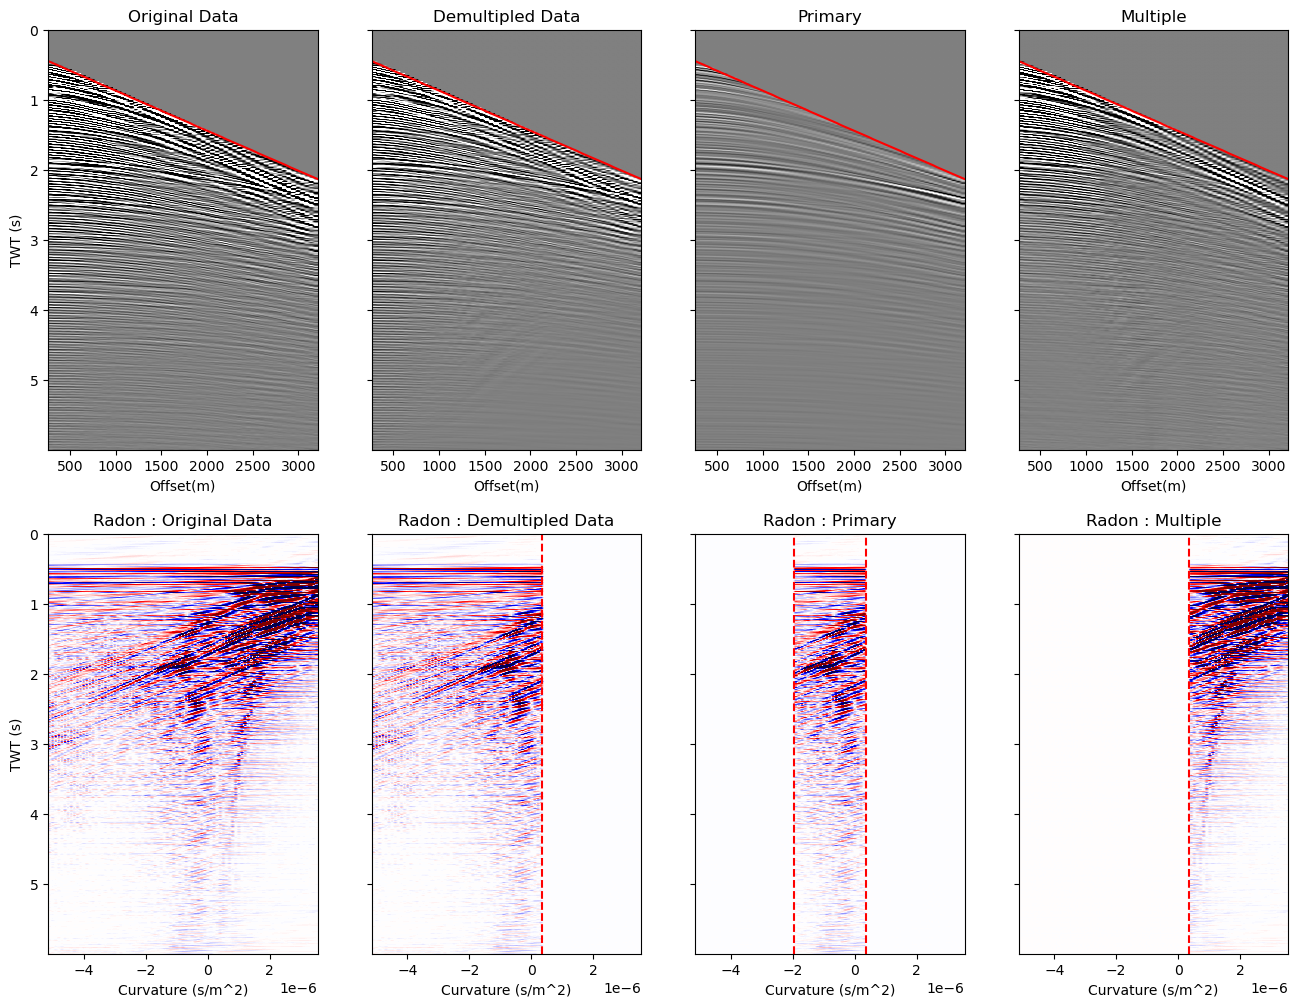

In [29]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(16, 12))

plot_tol = 32

axs[0,0].imshow(cmp_cut.T, aspect='auto',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],cmap='gray')
axs[0,0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,0].set_xlabel('Offset(m)')
axs[0,0].set_ylabel('TWT (s)')
axs[0,0].set_title('Original Data')

axs[0,2].imshow(prim.T, cmap='gray',extent=[offset[0],offset[-1],t[-1],t[0]],vmin=-10,vmax=10,aspect='auto')
axs[0,2].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,2].set_xlabel('Offset(m)')
axs[0,2].set_title('Primary')

axs[0,3].imshow(mult.T, aspect='auto',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],cmap='gray')
axs[0,3].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,3].set_xlabel('Offset(m)')
axs[0,3].set_title('Multiple')

axs[0,1].imshow(dmult.T, aspect='auto',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],cmap='gray')
axs[0,1].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,1].set_xlabel('Offset(m)')
axs[0,1].set_title('Demultipled Data')

vmax_px = 0.5

axs[1,0].imshow(xinv[idx_bot-plot_tol:idx_up+plot_tol,:].T,aspect='auto',vmax=vmax_px,vmin=-vmax_px,
              extent=[px[idx_bot-plot_tol],px[idx_up+plot_tol],t[-1],t[0]],cmap='seismic')

axs[1,0].set_title("Radon : Original Data")
axs[1,0].set_xlabel('Curvature (s/m^2)')
axs[1,0].set_ylabel('TWT (s)')

axs[1,2].imshow(filt_prim[idx_bot-plot_tol:idx_up+plot_tol,:].T,aspect='auto',vmax=vmax_px,vmin=-vmax_px,
              extent=[px[idx_bot-plot_tol],px[idx_up+plot_tol],t[-1],t[0]],cmap='seismic')

axs[1,2].axvline(px[idx_bot],color="r", linestyle="--")
axs[1,2].axvline(px[idx_up],color="r", linestyle="--")
axs[1,2].set_title("Radon : Primary")
axs[1,2].set_xlabel('Curvature (s/m^2)')

axs[1,3].imshow(filt_mult[idx_bot-plot_tol:idx_up+plot_tol,:].T,aspect='auto',vmax=vmax_px,vmin=-vmax_px,
              extent=[px[idx_bot-plot_tol],px[idx_up+plot_tol],t[-1],t[0]],cmap='seismic')

axs[1,3].axvline(px[idx_up],color="r", linestyle="--")
axs[1,3].set_title("Radon : Multiple")
axs[1,3].set_xlabel('Curvature (s/m^2)')

axs[1,1].imshow(filt_dmult[idx_bot-plot_tol:idx_up+plot_tol,:].T,aspect='auto',vmax=vmax_px,vmin=-vmax_px,
              extent=[px[idx_bot-plot_tol],px[idx_up+plot_tol],t[-1],t[0]],cmap='seismic')

axs[1,1].axvline(px[idx_up],ymin=0,ymax=0.59,color="r", linestyle="--")
axs[1,1].axvline(px[idx_up],ymin=0.59,color="r", linestyle="--")
axs[1,1].set_title("Radon : Demultipled Data")
axs[1,1].set_xlabel('Curvature (s/m^2)')

plt.savefig('Result_MOBIL')

plt.show()

### Semblance Check

In [30]:
t0axis = t
vrmsaxis = np.arange(1000, 4000, 50)
clip = 0.9

ss_prim,_ = semblance(prim.T, offset, t, t0axis, vrmsaxis, nsmooth=15)
ss_mult,_ = semblance(mult.T, offset, t, t0axis, vrmsaxis, nsmooth=15)
ss_dmult,_ = semblance(dmult.T, offset, t, t0axis, vrmsaxis, nsmooth=15)
ss_ori,_ = semblance(cmp_cut.T, offset, t, t0axis, vrmsaxis, nsmooth=15)

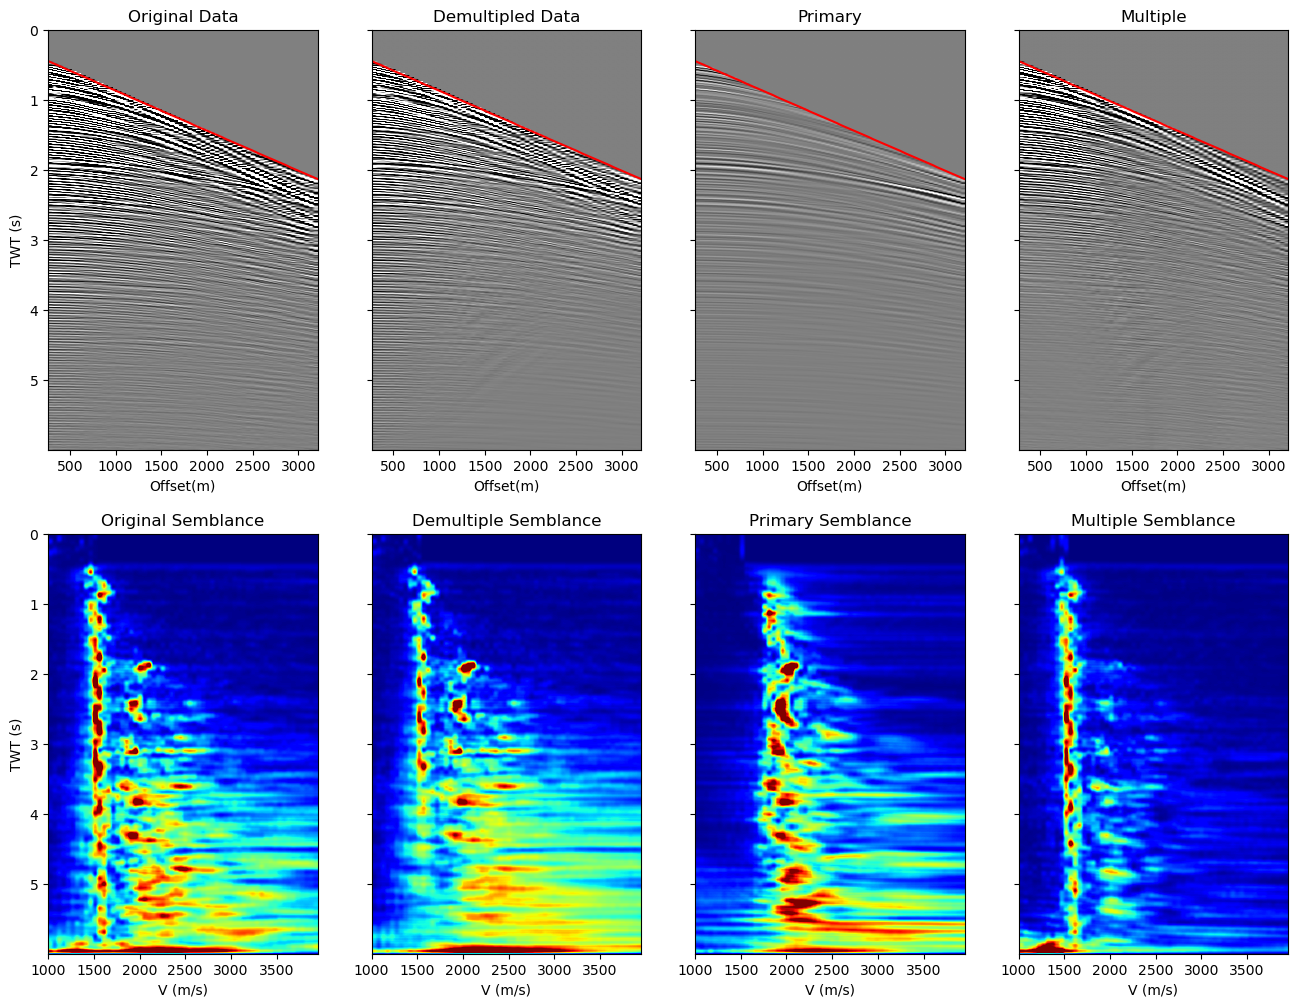

In [31]:
fig, axs = plt.subplots(2, 4 ,figsize=(16, 12),sharey=True)
clip = 0.6

axs[0,0].imshow(cmp_cut.T, cmap='gray',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],aspect='auto')
axs[0,0].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,0].set_xlabel('Offset(m)')
axs[0,0].set_ylabel('TWT (s)')
axs[0,0].set_title('Original Data')

axs[1,0].imshow(ss_ori, cmap='jet', vmin=0, vmax=ss_ori.max()*clip,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],t[-1],t[0]])
axs[1,0].set_title('Original Semblance')
axs[1,0].set_xlabel('V (m/s)')
axs[1,0].set_ylabel('TWT (s)')

axs[0,2].imshow(prim.T, cmap='gray',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],aspect='auto')
axs[0,2].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,2].set_xlabel('Offset(m)')
axs[0,2].set_title('Primary')

axs[1,2].imshow(ss_prim, cmap='jet', vmin=0, vmax=ss_prim.max()*clip,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],t[-1],t[0]])
axs[1,2].set_title('Primary Semblance')
axs[1,2].set_xlabel('V (m/s)')

axs[0,3].imshow(mult.T, cmap='gray',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],aspect='auto')
axs[0,3].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,3].set_xlabel('Offset(m)')
axs[0,3].set_title('Multiple')

axs[1,3].imshow(ss_mult, cmap='jet', vmin=0, vmax=ss_mult.max()*clip,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],t[-1],t[0]])
axs[1,3].set_title('Multiple Semblance')
axs[1,3].set_xlabel('V (m/s)')

axs[0,1].imshow(dmult.T, cmap='gray',vmax=10,vmin=-10,extent=[offset[0],offset[-1],t[-1],t[0]],aspect='auto')
axs[0,1].plot(offset[mask],itevent[mask]*dt,c='red')
axs[0,1].set_xlabel('Offset(m)')
axs[0,1].set_title('Demultipled Data')

axs[1,1].imshow(ss_dmult, cmap='jet', vmin=0, vmax=ss_dmult.max()*clip,aspect='auto',extent=[vrmsaxis[0],vrmsaxis[-1],t[-1],t[0]])
axs[1,1].set_title('Demultiple Semblance')
axs[1,1].set_xlabel('V (m/s)')

plt.savefig('Semblance Check_MOBIL')
plt.show()